In [1]:
import os
import datetime
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sqlalchemy import create_engine, sql

# matplotlib settings
mpl.rcParams['figure.figsize'] = (5, 3)
mpl.rcParams['axes.grid'] = False

In [2]:
#--------------------------------------------------------------------------
# Environment setup
#--------------------------------------------------------------------------

# get postgres environment variables
PG_HOST = os.getenv('PG_HOST')
PG_PORT = os.getenv('PG_PORT')
PG_DB_NAME = os.getenv('PG_DB_NAME')
PG_USERNAME = os.getenv('PG_USERNAME')
PG_PASSWORD = os.getenv('PG_PASSWORD')

# check for missing environment variables
if PG_HOST == None or PG_PORT == None or PG_DB_NAME == None or PG_USERNAME == None or PG_PASSWORD == None:
    print('[ ERROR ] Environment variables PG_HOST, PG_PORT, PG_DB_NAME, PG_USERNAME, or PG_PASSWORD not found.')

# hard-code table name
PG_TABLE = 'bars_minute_eastern'

In [3]:
#------------------------------------------------------------------------------
# Establish connections
#------------------------------------------------------------------------------

# connect to db and open a cursor to perform database operations
conn_string = "postgresql://{}:{}@{}:{}/{}".format(PG_USERNAME, PG_PASSWORD, PG_HOST, PG_PORT, PG_DB_NAME)
db = create_engine(conn_string)
conn = db.connect()

In [4]:
#------------------------------------------------------------------------------
# Pull data from db
#------------------------------------------------------------------------------

stock_bars_minute_df = pd.read_sql_query(sql=sql.text(f'select * from { PG_TABLE } where SYMBOL=\'NVDA\''), con=conn)

timestamps = pd.to_datetime(stock_bars_minute_df.pop('timestamp'))

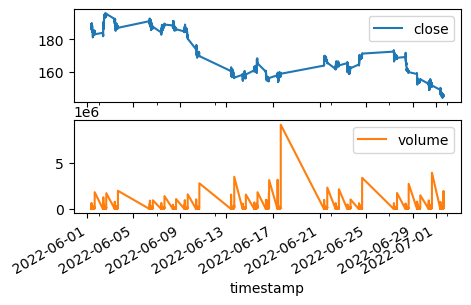

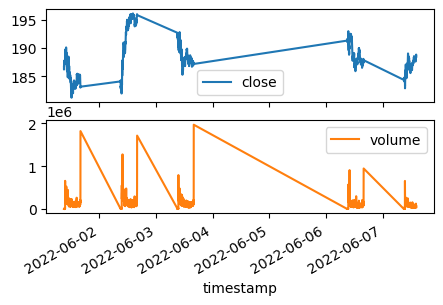

In [7]:
# plot close and volume
plot_cols = ['close', 'volume']

plot_features = stock_bars_minute_df[plot_cols]
plot_features.index = timestamps
_ = plot_features.plot(subplots=True)

plot_features = stock_bars_minute_df[plot_cols][:2000]
plot_features.index = timestamps[:2000]
_ = plot_features.plot(subplots=True)


Text(0.5, 1.0, 'Time of day signal')

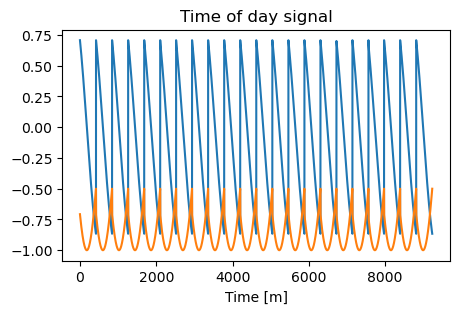

In [9]:
timestamp_s = timestamps.map(pd.Timestamp.timestamp)

seconds_per_day = 24*60*60
seconds_per_week = seconds_per_day*7
seconds_per_year = seconds_per_week*52.1429

stock_bars_minute_df['day-sin'] = np.sin(timestamp_s * (2 * np.pi / seconds_per_day))
stock_bars_minute_df['day-cos'] = np.cos(timestamp_s * (2 * np.pi / seconds_per_day))

stock_bars_minute_df['week-sin'] = np.sin(timestamp_s * (2 * np.pi / seconds_per_week))
stock_bars_minute_df['week-cos'] = np.cos(timestamp_s * (2 * np.pi / seconds_per_week))

stock_bars_minute_df['year-sin'] = np.sin(timestamp_s * (2 * np.pi / seconds_per_year))
stock_bars_minute_df['year-cos'] = np.cos(timestamp_s * (2 * np.pi / seconds_per_year))

plt.plot(np.array(stock_bars_minute_df['day-sin']))
plt.plot(np.array(stock_bars_minute_df['day-cos']))
plt.xlabel('Time [m]')
plt.title('Time of day signal')

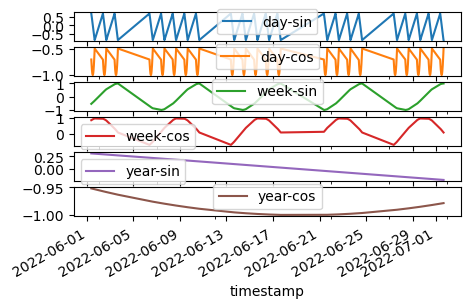

In [11]:
# plot close and volume
plot_cols = ['day-sin', 'day-cos', 'week-sin', 'week-cos','year-sin', 'year-cos']

plot_features = stock_bars_minute_df[plot_cols]
plot_features.index = timestamps
_ = plot_features.plot(subplots=True)